<a href="https://colab.research.google.com/github/JihenSkima/Keystroke-Dynamics-data-preprocessing-/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_fixed = pd.read_csv('/content/Fixed Text Typing Dataset.csv',index_col=False)
df_freq = pd.read_csv('/content/Frequency Dataset.csv',index_col=False)
df_user = pd.read_csv('/content/Participants Information.csv',index_col=False)


In [3]:
df_freq = df_freq.rename(columns={'User ID':'userId'})

# Remove useless columns

In [4]:
df_fixed = df_fixed.drop(columns='Unnamed: 0', axis=1)
df_freq = df_freq.drop(columns='Unnamed: 0',axis=1)
df_user = df_user.drop(columns='Unnamed: 0',axis=1)


In [5]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46871 entries, 0 to 46870
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   userId        46871 non-null  int64  
 1   emotionIndex  46871 non-null  object 
 2   index         46871 non-null  int64  
 3   keyCode       46846 non-null  object 
 4   keyDown       46846 non-null  object 
 5   keyUp         45558 non-null  object 
 6   D1U1          46846 non-null  object 
 7   D1U2          46606 non-null  object 
 8   D1D2          46606 non-null  float64
 9   U1D2          46606 non-null  object 
 10  U1U2          46606 non-null  object 
 11  D1U3          46364 non-null  object 
 12  D1D3          46364 non-null  float64
 13  answer        18781 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 5.0+ MB


# some exploration

In [6]:
df_fixed['emotionIndex'].unique()

array(['N', 'H', 'C', 'A', 'S'], dtype=object)

In [7]:
df_fixed.dtypes

,0
userId,int64
emotionIndex,object
index,int64
keyCode,object
keyDown,object
keyUp,object
D1U1,object
D1U2,object
D1D2,float64
U1D2,object


# Fix userId redundancy

In [8]:
# Émotions valides
valid_emotions = {'N', 'H', 'C', 'S', 'A'}


In [9]:

#Étape 2 : Vérifier les userId et leurs fréquences
user_id_counts = df_fixed['userId'].value_counts()
print("Nombre de userId uniques avant correction :", len(user_id_counts))
print("Fréquence des userId :\n", user_id_counts)


Nombre de userId uniques avant correction : 83
Fréquence des userId :
 userId
104    2046
93     1687
87     1586
120    1320
100    1195
       ... 
141     209
161     208
167     198
168     197
13      184
Name: count, Length: 83, dtype: int64


In [10]:

# Étape 3 : Identifier les sessions (blocs consécutifs de userId et emotionIndex)
sessions = []
current_user_id = None
current_emotion = None
current_session = []
for index, row in df_fixed.iterrows():
    if row['userId'] != current_user_id or row['emotionIndex'] != current_emotion:
        if current_session:
            start_time = df_fixed.loc[current_session[0], 'keyDown'] if 'keyDown' in df_fixed.columns else np.nan
            try:
                start_time = float(start_time) if not pd.isna(start_time) else np.nan
            except (ValueError, TypeError):
                start_time = np.nan
            sessions.append({
                'userId': current_user_id,
                'emotionIndex': current_emotion,
                'indices': current_session,
                'start_time': start_time
            })
        current_session = [index]
        current_user_id = row['userId']
        current_emotion = row['emotionIndex']
    else:
        current_session.append(index)
if current_session:
    start_time = df_fixed.loc[current_session[0], 'keyDown'] if 'keyDown' in df_fixed.columns else np.nan
    try:
        start_time = float(start_time) if not pd.isna(start_time) else np.nan
    except (ValueError, TypeError):
        start_time = np.nan
    sessions.append({
        'userId': current_user_id,
        'emotionIndex': current_emotion,
        'indices': current_session,
        'start_time': start_time
    })


In [11]:

# Étape 4 : Vérifier la validité des émotions
for session in sessions:
    if session['emotionIndex'] not in valid_emotions:
        print(f"Avertissement : Session userId={session['userId']}, emotionIndex={session['emotionIndex']} n'est pas valide (attendu : {valid_emotions}).")


In [12]:

# Étape 5 : Regrouper les sessions par userId
participants = {}
for session in sessions:
    user_id = session['userId']
    if user_id not in participants:
        participants[user_id] = []
    participants[user_id].append(session)

In [13]:



# Étape 6 : Détecter les userId dupliqués et assigner des participants
new_user_id_map = {}  # Mappe les sessions à de nouveaux userId
used_user_ids = set()
max_user_id = max(df_fixed['userId'].astype(int))  # Plus grand userId existant
participant_sessions = []  # Stocker les sessions par participant temporairement

for user_id, sessions in participants.items():
    # Trier les sessions par start_time (ou index si start_time est NaN)
    sessions.sort(key=lambda x: x['start_time'] if not np.isnan(x['start_time']) else x['indices'][0])

    # Initialiser le premier participant pour ce userId
    current_participant = [sessions[0]]
    current_start_time = sessions[0]['start_time']
    current_start_index = sessions[0]['indices'][0]

    # Regrouper les sessions proches
    for session in sessions[1:]:
        session_start_time = session['start_time']
        session_start_index = session['indices'][0]
        # Vérifier si la session est proche de la dernière session du participant actuel
        time_condition = (
            not np.isnan(current_start_time) and
            not np.isnan(session_start_time) and
            abs(current_start_time - session_start_time) < 3600000  # 1 heure
        )
        index_condition = abs(current_start_index - session_start_index) < 1000
        if time_condition or index_condition:
            current_participant.append(session)
        else:
            # Nouvelle session éloignée -> nouveau participant
            participant_sessions.append({
                'new_user_id': user_id if user_id not in used_user_ids else str(max_user_id + 1),
                'sessions': current_participant
            })
            if user_id in used_user_ids:
                max_user_id += 1
            used_user_ids.add(participant_sessions[-1]['new_user_id'])
            current_participant = [session]
            current_start_time = session_start_time
            current_start_index = session_start_index

    # Ajouter le dernier participant pour ce userId
    # Générer un nouvel ID propre
    if int(user_id) in used_user_ids:
        max_user_id += 1
        new_id = max_user_id
    else:
        new_id = int(user_id)

    used_user_ids.add(new_id)

    participant_sessions.append({
        'new_user_id': new_id,
        'sessions': current_participant
    })


In [14]:



# Étape 7 : Ajuster pour atteindre exactement 124 participants
participant_count = len(participant_sessions)
print(f"Nombre de participants identifiés initialement : {participant_count}")
if participant_count > 124:
    print(f"Avertissement : {participant_count} participants identifiés, mais 124 attendus. Tentative de fusion...")
    # Trier les participants par start_time pour fusionner les plus proches
    participant_sessions.sort(key=lambda x: min(s['start_time'] for s in x['sessions'] if not np.isnan(s['start_time']))
                            if any(not np.isnan(s['start_time']) for s in x['sessions'])
                            else min(s['indices'][0] for s in x['sessions']))

    # Fusionner les participants jusqu'à atteindre 124
    while len(participant_sessions) > 124:
        # Trouver les deux participants les plus proches
        min_distance = float('inf')
        merge_idx = None
        for i in range(len(participant_sessions) - 1):
            p1 = participant_sessions[i]
            p2 = participant_sessions[i + 1]
            p1_time = min(s['start_time'] for s in p1['sessions'] if not np.isnan(s['start_time'])) \
                      if any(not np.isnan(s['start_time']) for s in p1['sessions']) else float('inf')
            p2_time = min(s['start_time'] for s in p2['sessions'] if not np.isnan(s['start_time'])) \
                      if any(not np.isnan(s['start_time']) for s in p2['sessions']) else float('inf')
            p1_index = min(s['indices'][0] for s in p1['sessions'])
            p2_index = min(s['indices'][0] for s in p2['sessions'])
            time_distance = abs(p1_time - p2_time) if not np.isnan(p1_time) and not np.isnan(p2_time) else float('inf')
            index_distance = abs(p1_index - p2_index)
            distance = min(time_distance, index_distance)
            if distance < min_distance:
                min_distance = distance
                merge_idx = i

        if merge_idx is not None:
            # Fusionner les deux participants les plus proches
            participant_sessions[merge_idx]['sessions'].extend(participant_sessions[merge_idx + 1]['sessions'])
            participant_sessions.pop(merge_idx + 1)
        else:
            break  # Éviter une boucle infinie si aucune fusion n'est possible

Nombre de participants identifiés initialement : 118


In [15]:
# Étape 8 : Créer la correspondance finale des sessions aux userId
for participant in participant_sessions:
    new_user_id = participant['new_user_id']
    for session in participant['sessions']:
        new_user_id_map[tuple(session['indices'])] = new_user_id

In [16]:
# Étape 9 : Mettre à jour le dataset
for indices, new_user_id in new_user_id_map.items():
    df_fixed.loc[list(indices), 'userId'] = new_user_id

# Forcer les userId en int (si certains sont restés str)
df_fixed['userId'] = df_fixed['userId'].astype(int)

# Compter à nouveau
unique_user_ids = df_fixed['userId'].nunique()
print("Nombre de userId uniques après correction :", unique_user_ids)


Nombre de userId uniques après correction : 118


/tmp/ipython-input-16-1908037931.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '194' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_fixed.loc[list(indices), 'userId'] = new_user_id


In [17]:
# Étape 10 : Valider la correction
unique_user_ids = len(df_fixed['userId'].value_counts())
print("Nombre de userId uniques après correction :", unique_user_ids)
if unique_user_ids == 124:
    print("Correction réussie : 124 userId uniques correspondant aux 124 participants.")
else:
    print(f"Erreur : le nombre de userId uniques ({unique_user_ids}) ne correspond pas à 124.")


Nombre de userId uniques après correction : 118
Erreur : le nombre de userId uniques (118) ne correspond pas à 124.


In [18]:
# Étape 11 : Vérifier que chaque userId a au moins une session valide
for user_id in df_fixed['userId'].unique():
    user_emotions = df_fixed[df_fixed['userId'] == user_id]['emotionIndex'].unique()
    if not any(emotion in valid_emotions for emotion in user_emotions):
        print(f"Avertissement : userId {user_id} n'a pas de session avec une émotion valide ({valid_emotions}).")


In [19]:
df_fixed['userId'].nunique()

118

In [20]:
df_fixed

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,D1U3,D1D3,answer
0,100,N,3448,o,"1,58E+12","1,58E+12",90,2556,2479.0,2389,2466,2737,2610.0,NaN
1,100,N,3449,n,"1,58E+12","1,58E+12",77,258,131.0,54,181,744,650.0,NaN
2,100,N,3450,c,"1,58E+12","1,58E+12",127,613,519.0,392,486,795,719.0,NaN
3,100,N,3451,e,"1,58E+12","1,58E+12",94,276,200.0,106,182,2304,2232.0,NaN
4,100,N,3452,,"1,58E+12","1,58E+12",76,2104,2032.0,1956,2028,2271,2191.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46866,228,N,50314,t,"1,58E+12","1,58E+12",57,211,138.0,81,154,376,286.0,NaN
46867,228,N,50315,h,"1,58E+12","1,58E+12",73,238,148.0,75,165,461,342.0,NaN
46868,228,N,50316,e,"1,58E+12","1,58E+12",90,313,194.0,104,223,655,530.0,NaN
46869,228,N,50317,r,"1,58E+12","1,58E+12",119,461,336.0,217,342,NaN,NaN,NaN


In [21]:
df_fixed.isna().sum()

,0
userId,0
emotionIndex,0
index,0
keyCode,25
keyDown,25
keyUp,1313
D1U1,25
D1U2,265
D1D2,265
U1D2,265


# Removing the corrupted data


In [22]:
df_fixed = df_fixed[~df_fixed.isin([-1.58e12]).any(axis=1)]
df_fixed

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,D1U3,D1D3,answer
0,100,N,3448,o,"1,58E+12","1,58E+12",90,2556,2479.0,2389,2466,2737,2610.0,NaN
1,100,N,3449,n,"1,58E+12","1,58E+12",77,258,131.0,54,181,744,650.0,NaN
2,100,N,3450,c,"1,58E+12","1,58E+12",127,613,519.0,392,486,795,719.0,NaN
3,100,N,3451,e,"1,58E+12","1,58E+12",94,276,200.0,106,182,2304,2232.0,NaN
4,100,N,3452,,"1,58E+12","1,58E+12",76,2104,2032.0,1956,2028,2271,2191.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46866,228,N,50314,t,"1,58E+12","1,58E+12",57,211,138.0,81,154,376,286.0,NaN
46867,228,N,50315,h,"1,58E+12","1,58E+12",73,238,148.0,75,165,461,342.0,NaN
46868,228,N,50316,e,"1,58E+12","1,58E+12",90,313,194.0,104,223,655,530.0,NaN
46869,228,N,50317,r,"1,58E+12","1,58E+12",119,461,336.0,217,342,NaN,NaN,NaN


# Remove useless columns

In [23]:
#as we can see above, answer is a useless column ( 28090 null values )
df_fixed = df_fixed.drop(columns='answer',axis=1)

# Remove NaN values

In [24]:
df_fixed = df_fixed.dropna(subset=['keyUp'])
df_fixed

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,D1U3,D1D3
0,100,N,3448,o,"1,58E+12","1,58E+12",90,2556,2479.0,2389,2466,2737,2610.0
1,100,N,3449,n,"1,58E+12","1,58E+12",77,258,131.0,54,181,744,650.0
2,100,N,3450,c,"1,58E+12","1,58E+12",127,613,519.0,392,486,795,719.0
3,100,N,3451,e,"1,58E+12","1,58E+12",94,276,200.0,106,182,2304,2232.0
4,100,N,3452,,"1,58E+12","1,58E+12",76,2104,2032.0,1956,2028,2271,2191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46866,228,N,50314,t,"1,58E+12","1,58E+12",57,211,138.0,81,154,376,286.0
46867,228,N,50315,h,"1,58E+12","1,58E+12",73,238,148.0,75,165,461,342.0
46868,228,N,50316,e,"1,58E+12","1,58E+12",90,313,194.0,104,223,655,530.0
46869,228,N,50317,r,"1,58E+12","1,58E+12",119,461,336.0,217,342,NaN,NaN


In [25]:
df_fixed.describe()

,userId,index,D1D2,D1D3
count,45558.000000,45558.000000,45318.000000,45076.000000
mean,131.479938,27002.170310,449.205239,898.577758
std,61.733002,13577.496467,3451.088192,5000.124968
min,13.000000,3448.000000,1.000000,8.000000
25%,83.000000,15261.250000,162.000000,375.000000
50%,123.000000,27183.500000,236.000000,543.000000
75%,198.000000,38820.750000,401.000000,876.000000
max,228.000000,50318.000000,461478.000000,463588.000000


# Visualization

In [26]:
features = [ 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3']
df_temp = df_fixed[features + ['emotionIndex']].copy()


**1- with boxplots**

In [27]:
numeric_columns = df_fixed.select_dtypes(include='number').columns.tolist()
numeric_columns

['userId', 'index', 'D1D2', 'D1D3']

In [28]:
features = ['keyDown', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3']
df_corr = df_fixed[features + ['emotionIndex']].copy()

# Convertir les colonnes en float
for col in features:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')


ValueError: could not convert string to float: '1,58E+12'

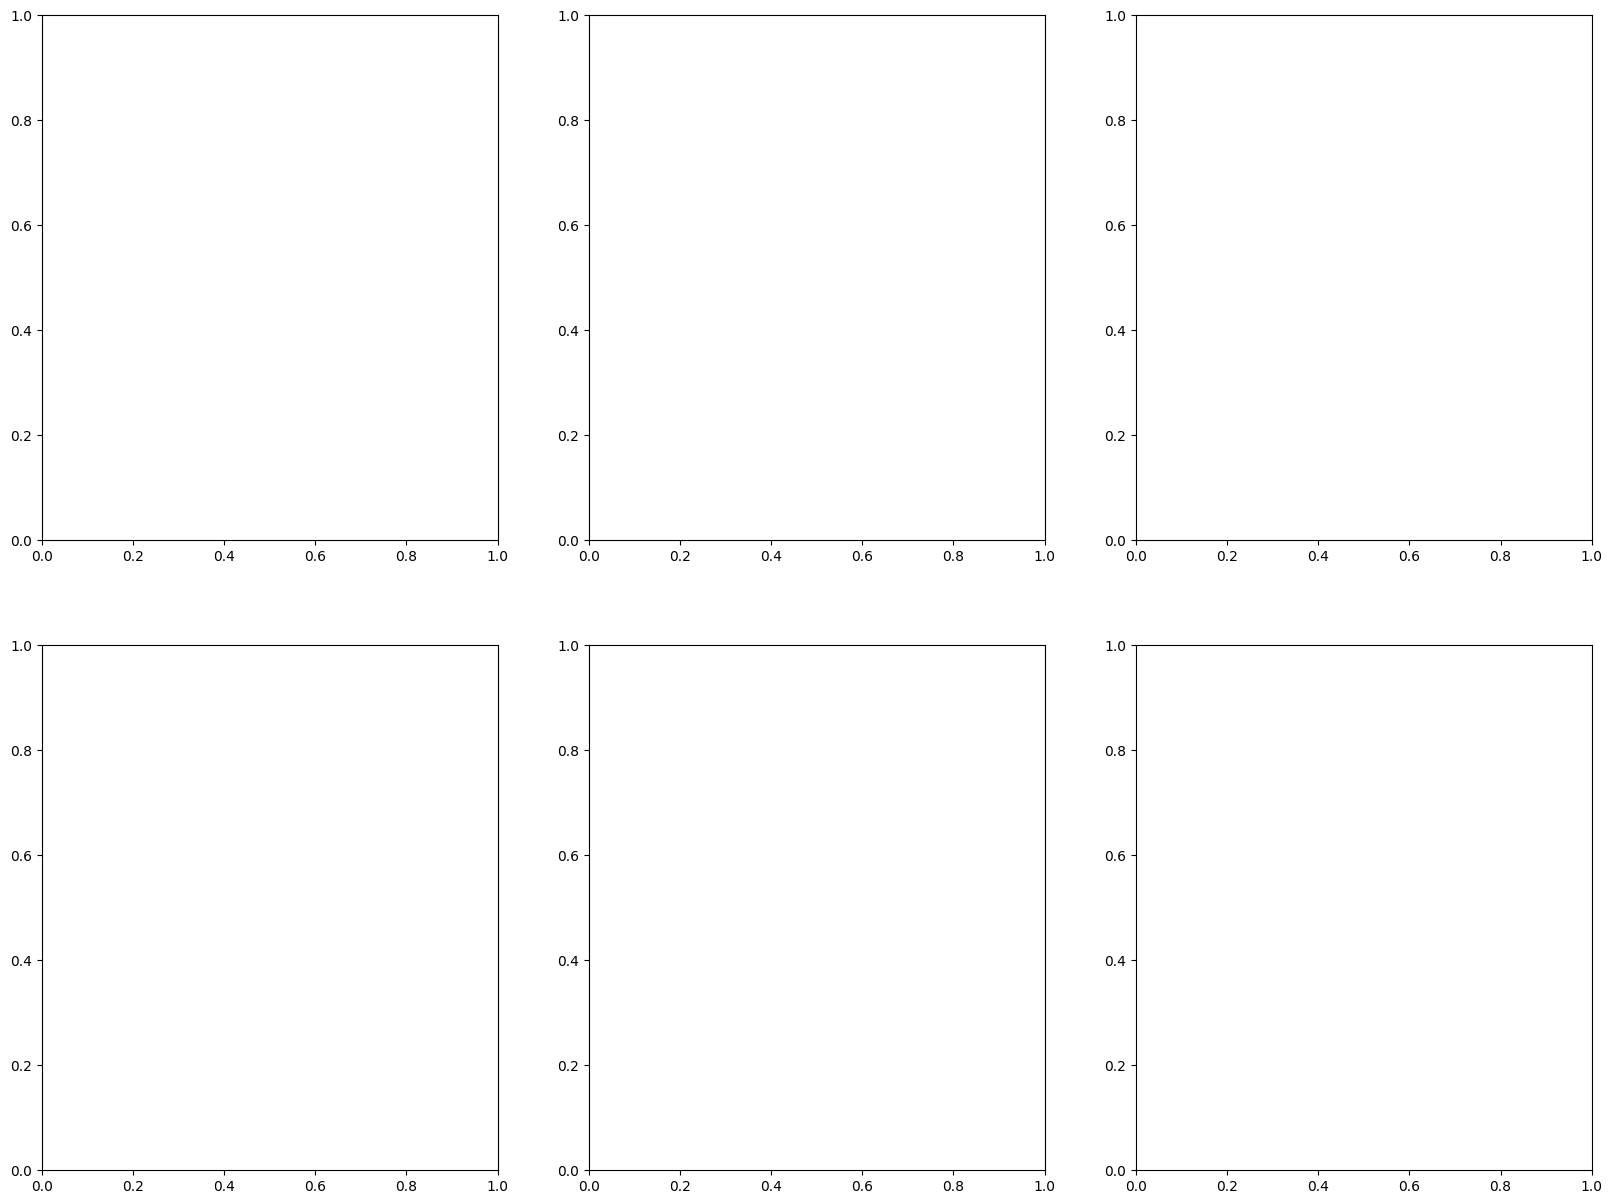

In [30]:
# Sélection des caractéristiques à inclure dans la matrice
features = ['keyDown', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3']

# Création d'une figure avec des sous-graphiques
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

# Noms complets des émotions pour les titres
emotion_names = {
    'N': 'Neutre',
    'H': 'Heureux',
    'A': 'Colère',
    'C': 'Concentration',
    'S': 'Tristesse'
}

# Calcul et affichage des matrices de corrélation pour chaque émotion
for i, emotion in enumerate(emotion_names.keys()):
    # Sélection des données pour l'émotion courante
    subset = df_fixed[df_fixed['emotionIndex'] == emotion][features]

    # Calcul de la matrice de corrélation
    corr_matrix = subset.corr()

    # Création de la heatmap
    sns.heatmap(corr_matrix,
                annot=True,
                fmt=".2f",
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                ax=axes[i],
                mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),
                cbar_kws={'shrink': 0.7})

    axes[i].set_title(f'Matrice de corrélation - {emotion_names[emotion]} ({emotion})', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

# Cacher le dernier subplot inutilisé
for j in range(len(emotion_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Matrices de corrélation des caractéristiques de frappe par état émotionnel',
             y=1.02, fontsize=18, fontweight='bold')
plt.savefig('correlation_matrices.png', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
# Calcul des corrélations par émotion
emotion_corrs = {}
for emotion in emotion_names.keys():
    subset = df_fixed[df_fixed['emotionIndex'] == emotion][features]
    emotion_corrs[emotion] = subset.corr()

# Calcul des différences par rapport à l'état neutre
plt.figure(figsize=(14, 12))
diff_matrix = emotion_corrs['H'] - emotion_corrs['N']  # Exemple: Heureux vs Neutre

sns.heatmap(diff_matrix,
            annot=True,
            fmt=".2f",
            cmap='RdBu_r',
            center=0,
            vmin=-0.5,
            vmax=0.5,
            cbar_kws={'label': 'Différence de corrélation'})

plt.title('Différence de corrélation: Heureux vs Neutre', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_difference_happy_vs_neutral.png', bbox_inches='tight', dpi=300)
plt.show()

ValueError: could not convert string to float: '1,58E+12'

In [ ]:
features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3']

# Calculer les moyennes par émotion
mean_values = df_fixed.groupby('emotionIndex')[features].mean().reset_index()

# Normaliser les données pour une meilleure visualisation
normalized = (mean_values[features] - mean_values[features].min()) / \
             (mean_values[features].max() - mean_values[features].min())

# Ajouter les émotions
normalized['emotionIndex'] = mean_values['emotionIndex']

# Préparer les données pour la heatmap
heatmap_data = normalized.set_index('emotionIndex').T

# Créer la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data,
            annot=mean_values.set_index('emotionIndex')[features].T.round(2),
            fmt="",
            cmap='viridis',
            cbar_kws={'label': 'Valeur normalisée'})

plt.title('Valeurs moyennes des caractéristiques par état émotionnel')
plt.xlabel('Émotion')
plt.ylabel('Caractéristique')
plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

# Préparer les données
features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3']
emotions = ['N', 'H', 'A', 'C', 'S']

# Calculer les valeurs F (ANOVA) et les p-values
f_values = []
p_values = []

for feature in features:
    groups = [df_fixed[df_fixed['emotionIndex'] == emotion][feature].dropna()
             for emotion in emotions]
    f, p = stats.f_oneway(*groups)
    f_values.append(f)
    p_values.append(p)

# Créer un DataFrame pour les résultats
results = pd.DataFrame({
    'Feature': features,
    'F_value': f_values,
    'p_value': p_values
})

# Trier par F_value
results = results.sort_values('F_value', ascending=False)

# Visualiser
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='F_value', data=results, palette='viridis')
plt.title('Importance des caractéristiques pour distinguer les émotions (ANOVA)')
plt.xlabel('Caractéristique')
plt.ylabel('Valeur F (plus haute = plus discriminante)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter les p-values
for i, row in enumerate(results.itertuples()):
    plt.text(i, row.F_value + 0.1, f'p={row.p_value:.2e}',
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()